# Tournament simulation using PyStan

In this notebook, I build a simple Bayesian model to predict the outcome of the tournament. Since the bracket deadline is soon, I don't have time to add comments and there is plenty to clean up and improve. Comments are welcome!

Main idea: assign score $\alpha_i$ to each team, predict $\sqrt{\Delta}$ where $\Delta$ is the difference in scores using $\sqrt{\Delta} \approx \alpha_i - \alpha_j + h$ where $h$ is the home-field advantage.

There is no validation, so use at your own risk, though the predictions do lack creativity so it must have captured some common trends.

Download data from [Kaggle](https://www.kaggle.com/c/womens-machine-learning-competition-2018).

In [1]:
import random
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import pystan as ps

In [2]:
first_season = 2012

In [3]:
def convert_Wloc(loc):
    if loc == "H":
        return 1
    if loc == "A":
        return -1
    return 0

In [4]:
rs_df = pd.read_csv("data_2018_w/WRegularSeasonCompactResults.csv")
t_df = pd.read_csv("data_2018_w/WNCAATourneyCompactResults.csv")

games = pd.concat((rs_df, t_df))
teams = pd.read_csv("data_2018_w/WTeams.csv")
seeds = pd.read_csv("data_2018_w/WNCAATourneySeeds.csv")
slots = pd.read_csv("data_2018_w/WNCAATourneySlots.csv")

# team conversions
tid_to_id = { team: idx for idx, team in enumerate(teams["TeamID"].factorize()[1]) }
id_to_tid = { idx: team for idx, team in enumerate(teams["TeamID"].factorize()[1]) }

def tid_to_name(tid):
    return teams[teams.TeamID == tid].iloc[0].TeamName

def id_to_name(idx):
    return tid_to_name(id_to_tid[idx])

name_to_tid = {id_to_name(idx): id_to_tid[idx] for idx in range(len(teams))}

# create extra tables
games["win_id"] = games.apply(lambda x: tid_to_id[x.WTeamID], 1)
games["los_id"] = games.apply(lambda x: tid_to_id[x.LTeamID], 1)
games["athome"] = games.apply(lambda x: convert_Wloc(x.WLoc), 1)
games["period"] = np.minimum(games.DayNum // 45, 2)

games = games[games["Season"] >= first_season]

games["season"] = games.Season - first_season
games["dscore"] = np.sqrt(games.WScore - games.LScore)

In [5]:
games.groupby([games.Season, games.period]).count()

Season  DayNum  WTeamID  WScore  LTeamID  LScore  WLoc  NumOT  \
Season period                                                                  
2012   0         1478    1478     1478    1478     1478    1478  1478   1478   
       1         1882    1882     1882    1882     1882    1882  1882   1882   
       2         1817    1817     1817    1817     1817    1817  1817   1817   
2013   0         1611    1611     1611    1611     1611    1611  1611   1611   
       1         1861    1861     1861    1861     1861    1861  1861   1861   
       2         1775    1775     1775    1775     1775    1775  1775   1775   
2014   0         1588    1588     1588    1588     1588    1588  1588   1588   
       1         1901    1901     1901    1901     1901    1901  1901   1901   
       2         1826    1826     1826    1826     1826    1826  1826   1826   
2015   0         1499    1499     1499    1499     1499    1499  1499   1499   
       1         1939    1939     1939    1939     1939    1939  1939   1939   
       2         1840    1840     1840    1840     1840    1840  1840   1840   
2016   0         1492    1492     1492    1492     1492    1492  1492   1492   
       1         1908    1908     1908    1908     1908    1908  1908   1908   
       2         1872    1872     1872    1872     1872    1872  1872   1872   
2017   0         1507    1507     1507    1507     1507    1507  1507   1507   
       1         1897    1897     1897    1897     1897    1897  1897   1897   
       2         1869    1869     1869    1869     1869    1869  1869   1869   
2018   0         1508    1508     1508    1508     1508    1508  1508   1508   
       1         1880    1880     1880    1880     1880    1880  1880   1880   
       2         1821    1821     1821    1821     1821    1821  1821   1821   

               win_id  los_id  athome  period  season  dscore  
Season period                                                  
2012   0         1478    1478    1478    1478    1478    1478  
       1         1882    1882    1882    1882    1882    1882  
       2         1817    1817    1817    1817    1817    1817  
2013   0         1611    1611    1611    1611    1611    1611  
       1         1861    1861    1861    1861    1861    1861  
       2         1775    1775    1775    1775    1775    1775  
2014   0         1588    1588    1588    1588    1588    1588  
       1         1901    1901    1901    1901    1901    1901  
       2         1826    1826    1826    1826    1826    1826  
2015   0         1499    1499    1499    1499    1499    1499  
       1         1939    1939    1939    1939    1939    1939  
       2         1840    1840    1840    1840    1840    1840  
2016   0         1492    1492    1492    1492    1492    1492  
       1         1908    1908    1908    1908    1908    1908  
       2         1872    1872    1872    1872    1872    1872  
2017   0         1507    1507    1507    1507    1507    1507  
       1         1897    1897    1897    1897    1897    1897  
       2         1869    1869    1869    1869    1869    1869  
2018   0         1508    1508    1508    1508    1508    1508  
       1         1880    1880    1880    1880    1880    1880  
       2         1821    1821    1821    1821    1821    1821

In [6]:
len(games)

36771

# Simple Stan model

In [7]:
stan_code = """
data {
    int<lower=0> nteams; // number of teams
    int<lower=1> nseasons; // number of seasons
    int<lower=1> nperiods; // number of periods
    int<lower=0> N; // number of observations
    
    real dscore[N]; // Outcome
    int tid[N]; // Team
    int oid[N]; // Opponent
    int location[N]; // location of game
    int season[N]; // Season of game
    int period[N]; // Period in season
}
transformed data {}
parameters {
    real home_advantage;
    real team_initial[nteams];
    real dteam_seasons[nteams, nseasons-1];
    real team_periods[nteams, nseasons, nperiods];
    
    // evolution of teams
    real<lower=0.01> sigma_team0;
    real<lower=0.01> sigma_team_season;
    real<lower=0.01> sigma_team_period;
    
    // variance for home game advantage
    real<lower=0.1, upper=3> sigma_home;
    
    // variance in outcome
    real<lower=0.1, upper=5> sigma_score;
}
transformed parameters {
    vector[N] home_quality;
    vector[N] away_quality;
    vector[N] xb;
    
    real team_seasons[nteams, nseasons];
    
    for (t in 1:nteams) {
        team_seasons[t, 1] = team_initial[t];
        for (s in 2:nseasons) {
            team_seasons[t, s] = team_seasons[t, s-1] + dteam_seasons[t, s-1];
        }
    }
    
    for(i in 1:N) {
        home_quality[i] = team_seasons[tid[i], season[i]] + team_periods[tid[i], season[i], period[i]];
        away_quality[i] = team_seasons[oid[i], season[i]] + team_periods[oid[i], season[i], period[i]];
        xb[i] = home_advantage * location[i] + home_quality[i] - away_quality[i];
    }
}
model {
    home_advantage ~ normal(0.1, sigma_home);
    team_initial ~ normal(0.0, sigma_team0);
    
    for (t in 1:nteams){
        dteam_seasons[t] ~ normal(0.0, sigma_team_season);
        
        for (s in 1:nseasons) {
            team_periods[t, s] ~ normal(0, sigma_team_period);
        }
    }
    
    // outcome
    dscore ~ normal(xb, sigma_score);
}
generated quantities {
}
"""


In [8]:
stan_data = {
    "nteams": len(id_to_tid),
    "nseasons": max(games.season)+1,
    "nperiods": max(games.period)+1,
    "N": len(games),
    "dscore": games.dscore,
    "tid": games.win_id+1,
    "oid": games.los_id+1,
    "season": games.season + 1,
    "period": games.period + 1,
    "location": games.athome
}

print(f"Number of games: {len(games)}")

Number of games: 36771


In [9]:
stan_iters = 400
stan_fit = ps.stan(model_code=stan_code, data=stan_data, iter=stan_iters, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_426cbc025229be74ca6f7113d0e6534d NOW.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
stan_params = stan_fit.extract(["sigma_score", "home_advantage", "team_seasons", "team_periods"])

In [11]:
sigma_score = stan_params["sigma_score"]

(array([ 2.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  5.,  0.,  3.,  5.,
         4.,  7., 10., 13., 13.,  8.,  8., 16., 15., 13., 13., 11., 21.,
        18., 12., 19., 17., 20., 14., 14., 18., 16., 15.,  5., 16.,  9.,
         6.,  8.,  4.,  2.,  3.,  2.,  2.,  3.,  2.,  1.,  2.]),
 array([2.44451527, 2.4456613 , 2.44680732, 2.44795334, 2.44909937,
        2.45024539, 2.45139141, 2.45253744, 2.45368346, 2.45482948,
        2.45597551, 2.45712153, 2.45826755, 2.45941358, 2.4605596 ,
        2.46170562, 2.46285165, 2.46399767, 2.46514369, 2.46628972,
        2.46743574, 2.46858176, 2.46972779, 2.47087381, 2.47201984,
        2.47316586, 2.47431188, 2.47545791, 2.47660393, 2.47774995,
        2.47889598, 2.480042  , 2.48118802, 2.48233405, 2.48348007,
        2.48462609, 2.48577212, 2.48691814, 2.48806416, 2.48921019,
        2.49035621, 2.49150223, 2.49264826, 2.49379428, 2.4949403 ,
        2.49608633, 2.49723235, 2.49837837, 2.4995244 , 2.50067042,
        2.50181644]),
 <a list of 50

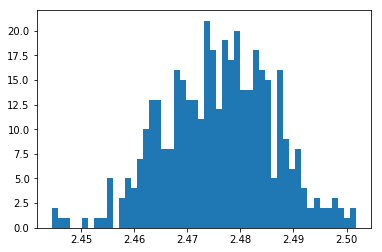

In [12]:
plt.hist(sigma_score, bins=50)

In [13]:
team_seasons = stan_params["team_seasons"]
team_periods = stan_params["team_periods"]

In [14]:
def get_team_path(tid, i=None):
    N = len(team_seasons)

    if i == None:
        i = random.randint(0, N-1)
    
    path = []
    for season in range(stan_data["nseasons"]):
        for period in range(stan_data["nperiods"]):
            path.append(team_seasons[i, tid, season] + team_periods[i, tid, season, period])
            
    return path

([<matplotlib.axis.XTick at 0x115948240>,
 <a list of 7 Text xticklabel objects>)

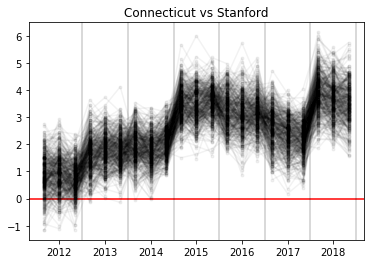

In [19]:
teamA = "Connecticut"
teamB = "Stanford"
tid = tid_to_id[name_to_tid[teamA]]
oid = tid_to_id[name_to_tid[teamB]]


f, ax = plt.subplots()

ax.axhline(0, color="red")

for trace in range(stan_iters):
    ax.plot([a-b for a, b in zip(get_team_path(tid, trace), get_team_path(oid, trace))], 
            ".-", color="black", alpha=0.05)
    
ax.set_title("{} vs {}".format(teamA, teamB))

for i in range(stan_data["nseasons"]):
    ax.axvline(2.5 + 3*i, color="black", alpha=0.2)
    
# set the locations of the xticks
year_ticks = [1+3*i for i in range(stan_data["nseasons"])]
plt.xticks( year_ticks )

# set the locations and labels of the xticks
plt.xticks( year_ticks,  [first_season+i for i in range(len(year_ticks))])


# Simulating the tournament

In [16]:
tournament_year = 2018

yr = tournament_year - first_season

In [24]:
tourny_teams = seeds[seeds.Season == tournament_year].TeamID.unique()
tourny_teams_ids = [tid_to_id[t] for t in tourny_teams]


# show top 10 teams
qualified_teams = sorted([(id_to_name(idx), get_team_path(idx)[3*yr + 2]) for idx in tourny_teams_ids],
                         key=lambda t: -t[1])

In [25]:
qualified_teams

[('Baylor', 7.492970724827414),
 ('Connecticut', 7.358913037861468),
 ('Mississippi St', 7.0446419557736775),
 ('Notre Dame', 7.032592130752012),
 ('Oregon', 6.094129736005403),
 ('Texas', 5.814552007544803),
 ('Louisville', 5.760184131862879),
 ('South Carolina', 5.354496745933524),
 ('Florida St', 5.199260967613642),
 ('Stanford', 5.118602688961447),
 ('Ohio St', 4.944337395363231),
 ('South Florida', 4.8118125538994825),
 ('Texas A&M', 4.703794039820233),
 ('Tennessee', 4.560991614449705),
 ('UCLA', 4.50437611576587),
 ('Oregon St', 4.418414855858643),
 ('S Dakota St', 4.3547203073685745),
 ('Maryland', 4.2469534595883465),
 ('Iowa', 4.1978364074501),
 ('Duke', 4.1078884178718535),
 ('Villanova', 4.088486778196426),
 ('California', 3.9784155526523937),
 ('DePaul', 3.908857245796332),
 ('Michigan', 3.8539210259774745),
 ('WI Green Bay', 3.7655248986146646),
 ('Marquette', 3.623305839054543),
 ('Georgia', 3.6078226619459315),
 ('Princeton', 3.3893905669757465),
 ('NC State', 3.3416584

# Tournament simulation

In [28]:
slots.head()

,Slot,StrongSeed,WeakSeed
0,R1W1,W01,W16
1,R1W2,W02,W15
2,R1W3,W03,W14
3,R1W4,W04,W13
4,R1W5,W05,W12


In [29]:
tournament = slots.set_index("Slot").to_dict("index")
# purge initial playoffs

tournament = {k: (v["StrongSeed"], v["WeakSeed"]) for k, v in tournament.items()}# if v["StrongSeed"][-1] != "a"}

In [30]:
initial = seeds[seeds.Season == tournament_year][["Seed", "TeamID"]].set_index("Seed").to_dict("index")

initial = {k: v["TeamID"] for k, v in initial.items()}# if k[-1] not in ["a", "b"]}

# initial["W11"] = 1425
# initial["W16"] = 1291
# initial["Y16"] = 1413
# initial["Z11"] = 1243

In [31]:
def simulate_game(A, B, trace):
    """
    Simulates game between teams A and B
    
    Returns: winner, loser, margin
    """
    yr = tournament_year - first_season
    idA = tid_to_id[A]
    idB = tid_to_id[B]
    
    # find team coefficients
    alpha_a = get_team_path(idA, trace)[3*yr+2]
    alpha_b = get_team_path(idB, trace)[3*yr+2]
    
    sqrt_score = random.gauss(alpha_a - alpha_b, sigma_score[trace])
    
    # return result
    if sqrt_score >= 0:
        return A, B, sqrt_score**2
    
    return B, A, sqrt_score**2

Checking whether simulations make sense. Win percentage seem a little conservative between number 1 and number 16 seed, which is normal for this type of model. The predicted scores are clearly over-dispersed; that is due to the square root. However, it shouldn't influence the simulations too much.

Simulating Virginia vs Villanova
Virginia wins 47.25%


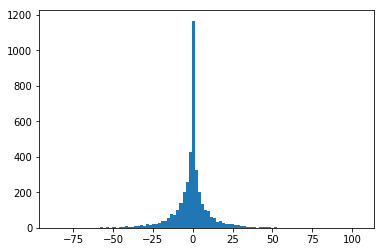

In [32]:
team_a = name_to_tid["Virginia"]
team_b = name_to_tid["Villanova"]
tid_to_name(team_a), tid_to_name(team_b)

raw_games = []
for _ in range(10):
    raw_games += [simulate_game(team_a, team_b, t) for t in range(stan_iters)]
    
final_scores = [(2*(a==team_a)-1) * score for a, b, score in raw_games]

print(f"Simulating {tid_to_name(team_a)} vs {tid_to_name(team_b)}")
a_win_perc = len([s for s in final_scores if s > 0]) / len(final_scores)
print(f"{tid_to_name(team_a)} wins {100*a_win_perc}%")

f = plt.hist(final_scores, bins=100, label="Final score")

In [33]:
def simulate_tournament(trace=0):
    results = {seed: team for seed, team in initial.items()}
    games = []
    
    for match, (teamA, teamB) in tournament.items():
        winner, loser, score = simulate_game(results[teamA], results[teamB], trace)
        results[match] = winner
        # round of game
        r = match[1]
        games.append((winner, loser, score, r))
    
    # clean initial seeds
    clean_results = {r: tid_to_name(winner)
            for r, winner in results.items() if r[0] == "R"}
    
    return clean_results, games

## Simulate a single tournament

In [34]:
results, games = simulate_tournament()

for tidA, tidB, score, rnd in games:
    print("Round {3}: {0:<20} def.    {1:<20}  {2}".format(tid_to_name(tidA), tid_to_name(tidB), int(score), rnd))

Round 1: Connecticut          def.    St Francis PA         34
Round 1: South Carolina       def.    NC A&T                40
Round 1: Florida St           def.    Ark Little Rock       16
Round 1: Georgia              def.    Mercer                22
Round 1: Duke                 def.    Belmont               29
Round 1: South Florida        def.    Buffalo               0
Round 1: California           def.    Virginia              8
Round 1: Miami FL             def.    Quinnipiac            0
Round 1: Notre Dame           def.    CS Northridge         32
Round 1: Oregon               def.    Seattle               48
Round 1: Ohio St              def.    G Washington          15
Round 1: Drake                def.    Texas A&M             16
Round 1: DePaul               def.    Oklahoma              0
Round 1: LSU                  def.    C Michigan            3
Round 1: WI Green Bay         def.    Minnesota             1
Round 1: Villanova            def.    S Dakota St           2

# Simulate many tournaments

In [35]:
round_counters = defaultdict(Counter)
# (2, 2) prior
game_aggregator = defaultdict(lambda: (0, 0))

def update_aggregates(game_aggregator, games):
    for A, B, _, _ in games:
        winner = A
        a = min(A, B)
        b = max(A, B)
        wins_a, wins_b = game_aggregator[(a, b)]
        if a == winner:
            game_aggregator[(a, b)] = wins_a + 1, wins_b
        else:
            game_aggregator[(a, b)] = wins_a, wins_b+1
            
def perc_counter(cntr):
    total = sum(cntr.values())
    return sorted([(team, cnt/total) for team, cnt in cntr.items()], key=lambda x: -x[1])

In [73]:
for itr in range(5000):
    if itr % 1000 == 0:
        print(".", end="")
    trace = random.randint(0, stan_iters-1)
    sim, games = simulate_tournament(trace)
    update_aggregates(game_aggregator, games)
    for rnd, team in sim.items():
        round_counters[rnd].update([team]) 

.....

In [74]:
percentages = {rnd: perc_counter(c) for rnd, c in round_counters.items()}

for rnd, outcome_teams in percentages.items():
    print("Round: {}".format(rnd))
    for team, perc in outcome_teams:
        print("{:>3.1f}% : {}".format(100*perc, team))
    print("-"*10)

Round: R1W1
99.9% : Connecticut
0.1% : St Francis PA
----------
Round: R1W2
98.9% : South Carolina
1.1% : NC A&T
----------
Round: R1W3
92.4% : Florida St
7.6% : Ark Little Rock
----------
Round: R1W4
67.2% : Georgia
32.8% : Mercer
----------
Round: R1W5
74.9% : Duke
25.1% : Belmont
----------
Round: R1W6
68.4% : South Florida
31.6% : Buffalo
----------
Round: R1W7
59.5% : California
40.5% : Virginia
----------
Round: R1W8
62.9% : Miami FL
37.1% : Quinnipiac
----------
Round: R1X1
99.7% : Notre Dame
0.3% : CS Northridge
----------
Round: R1X2
99.4% : Oregon
0.6% : Seattle
----------
Round: R1X3
91.3% : Ohio St
8.7% : G Washington
----------
Round: R1X4
72.1% : Texas A&M
27.9% : Drake
----------
Round: R1X5
61.1% : DePaul
38.9% : Oklahoma
----------
Round: R1X6
50.8% : C Michigan
49.2% : LSU
----------
Round: R1X7
56.8% : WI Green Bay
43.2% : Minnesota
----------
Round: R1X8
58.5% : S Dakota St
41.5% : Villanova
----------
Round: R1Y1
99.8% : Mississippi St
0.2% : Nicholls St
----------

# Submission

In [75]:
sample_submission = pd.read_csv("data_2018_w/WSampleSubmissionStage2.csv")
sample_submission.head()

,ID,Pred
0,2018_3110_3113,0.5
1,2018_3110_3114,0.5
2,2018_3110_3124,0.5
3,2018_3110_3125,0.5
4,2018_3110_3129,0.5


In [76]:
prior = 25
preds = []
for idx, row in sample_submission.iterrows():
    _, a, b = row.ID.split("_")
    wa, wb = game_aggregator[(int(a), int(b))]
    prediction = (wa+prior) / (wa + wb + 2*prior)
    preds.append(("2018_{}_{}".format(a, b), prediction))


In [77]:
submission = pd.DataFrame(preds)
submission.columns = ["ID", "Pred"]

In [78]:
submission.head()

,ID,Pred
0,2018_3110_3113,0.285714
1,2018_3110_3114,0.500000
2,2018_3110_3124,0.490196
3,2018_3110_3125,0.500000
4,2018_3110_3129,0.500000


In [81]:
# number of non-coinflip predictions
1-sum([1 for matchup, score in preds if score == 0.5]) / len(preds)

0.4508928571428571

## Save csv

In [82]:
submission.to_csv("womens_2018_submission_1.csv", index=False)

In [171]:
team_a = "Virginia"
team_b = "Duke"

tid, oid = name_to_tid[team_a], name_to_tid[team_b]

wa, wb = game_aggregator[(min(tid, oid), max(tid, oid))]
if tid == min(tid, oid):
    print("{} beats {} with probability {:.2f}".format(team_a, team_b, wa / (wa+wb)))
else:
    print("{} beats {} with probability {:.2f}".format(team_b, team_a, wa / (wa+wb)))

Duke beats Virginia with probability 0.45


In [181]:
tid_to_name(1233)

'Iona'

In [179]:
submission.sort_values("Pred").tail()

,ID,Pred
565,2018_1153_1460,0.880420
969,2018_1199_1300,0.884354
992,2018_1199_1411,0.889571
1216,2018_1242_1335,0.903771
852,2018_1181_1233,0.937066


In [183]:
round_counters["R1W1"]

Counter({'Long Island': 110, 'Radford': 565, 'Villanova': 37325})